In [12]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

# import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

from astropy.io import fits

In [13]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-Library/NPGMI Update.ipynb"

### Contrast as a function of L1 and d

In [ ]:
d = np.linspace(2, 37,106) *1e-3
slitdens = 200e-6
xbin = 0.5e-6
d, L1dens = force_broadcast(d, np.linspace(L/4,3*L/4,120))

G1sd = {"p":p, "L1": L1dens, "phi":phi}
G1sd["L2"] = d



G2sd = {"p":p, "L1": G1sd["L1"] +  G1sd["L2"], "phi":phi}
G2sd["L2"] = L - (G1sd["L1"] + G1sd["L2"])


simapts = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}
siminit = {"lam":lam, "plam": plam, "L":L,"d":G1sd["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid","slitx":slitdens, "res": res, "batches" : 25000}

In [ ]:
t0 = time()



simdens = PGMI(simaptssg,siminitsg)
simdens.propagate_to("G1")
simdens.propagate_to("G2")
simdens.generate_after("G2")

print(time() - t0, "seconds")

In [ ]:
p2lam_mult = dp2overlam*np.linspace(1,6,6)/2
print(p2lam_mult)
# print(dsg[np.argmin(abs(dsg[:,None] - p2lam_mult[None,:]),axis = 0)])


In [ ]:
rawdens = simdens.raw[:,simdens.raw.shape[-2]//2]
slitdens, resdens = generate_stepfunc(200e-6,xbin), generate_stepfunc(100e-6,xbin)
rawdens, slitdens = force_equal_dims(rawdens,slitdens)
rawdens, resdens = force_equal_dims(rawdens, resdens)

convdens = oaconvolve(oaconvolve(rawdens, slitdens,axes = -1,mode = "valid"), resdens, axes = -1, mode = "valid")
print(convdens.shape,slitdens.shape,resdens.shape)
densx = np.linspace(0,camsize,convdens.shape[-1])

In [ ]:
fitparamsLover2 = np.array([best_fit_moire_period(cosine_func,densx,convdens[i],psg,Lsg,dsg[i]) for i in range(convdens.shape[0])])
contLover2 = np.abs(fitparamsLover2[...,1]/fitparamsLover2[...,0])

In [ ]:
L1jpratio = (L1jp[0] -a)/Ljp * Lsg
print(L1jpratio)


In [ ]:
L1dens = L1dens.squeeze()
dsg = dsg.squeeze()
fig,ax = plt.subplots(figsize = (22,20))
c = ax.imshow(simdens.contrast.T, aspect = "auto", origin = "lower", extent = (dsg[0],dsg[-1],L1dens[0],L1dens[-1],))
cbar = fig.colorbar(c)
cbar.ax.tick_params(labelsize = 30)
cbar.ax.set_title("Contrast", fontsize = 30)

ax.set_yticks(L1dens[::len(L1dens)//2 -1])
ax.set_yticklabels([r"$\frac{L}{4}$",r"$\frac{L}{2}$",r"$\frac{3L}{4}$"], fontsize = 50)
ax.set_xticks(p2lam_mult)
ax.set_xticklabels([r"$\frac{p^2}{2\lambda}$",r"$\frac{p^2}{\lambda}$",r"$\frac{3p^2}{2\lambda}$",r"$\frac{2p^2}{\lambda}$",\
                   r"$\frac{5p^2}{2\lambda}$",r"$\frac{3p^2}{\lambda}$"], fontsize = 50)

ax.axhline(L1jpratio[0], color = "blue", ls = "--", linewidth = 5)
ax.axhline(L1jpratio[1], color = "red", ls = "--", linewidth = 5)
ax.axhline(L1jpratio[2], color = "black", ls = "--", linewidth = 5)

ax.set_xlabel(r"Separation distance $d$", fontsize = 50)
ax.set_ylabel(r"$L_1$", fontsize = 50)
# ax.axvline(dp2overlam/2)
fig.savefig("contL1figure.png")

plt.show()
plt.close(fig)

### Data Analysis

In [ ]:

def get_outlier_mask(data_arr,outlier_indices):
    mask = np.full(data_arr.shape,True)
    for i in range(data_arr.shape[0]):
        for ind in outlier_indices[i]:
            mask[i,ind] = False
    return mask



In [ ]:
t0 = time()

exp1path = r"C:\Users\gabri\Documents\Python Scripts\JPARC experiment\exp1"

image_side = 2048


cm_per_pixel = 6/1944 # 6.32 cm camera total
rotdegs = [1.2,1,1,1,0.3,0]

exp1filtered = np.array([[process_tfl(img, rotdegs[i], 5)[20:image_side - 100, 20:image_side - 100] for img in np.array(tfl.imread(exp1path  + "\\" + path))]\
                         for i, path in enumerate(os.listdir(exp1path))])

print(time() - t0, "seconds")


In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

c = ax1.imshow(exp1filtered[monoindices[-1],4], aspect = "auto")

ax1.axvline(960)
# plt.xlim(700,1200)
fig.colorbar(c)

ax1.set_xlabel("Camera x-axis (cm)")
ax1.set_ylabel("Camera y-axis (cm)")

# fig.savefig("sample.jpg")

plt.show()
plt.close(fig)

In [ ]:
contregion = np.empty((exp1filtered.shape[:2]))
Ldata = 8.2955
ddata = np.linspace(4.5,44.5,21)*1e-3
pdata = 3e-6


In [ ]:
t0 = time()

sh = exp1filtered.shape


region = exp1filtered[...,sh[-2]//3:2*sh[-2]//3, sh[-1]//2:]

sh  = region.shape


camx = np.linspace(0, sh[-1], sh[-1]) * cm_per_pixel *1e-2

exp1slice = abs(np.nanmean(region,axis = -2))


jpdatafitted = np.empty(exp1slice.shape)
jpdataparams = np.empty((*exp1slice.shape[:-1],4))



for i in range(exp1slice.shape[0]):
    for j in range(exp1slice.shape[1]):
            profile = exp1slice[i,j]
            jpdataparams[i,j] = best_fit_moire_period(cosine_func, camx, profile, pdata,Ldata,ddata[j])
            jpdatafitted[i,j] = cosine_func(camx,*jpdataparams[i,j])


datacont = np.abs(jpdataparams[...,1]/jpdataparams[...,0])
datafreq = 1/(jpdataparams[...,2])

print(time() - t0, "seconds")

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(camx,exp1slice[0,9])
ax1.plot(camx,jpdatafitted[0,9])


plt.show()

In [ ]:


runs = [re.findall('[0-9]+', i)[0] for i in os.listdir(exp1path)]

monoindices = [runs.index(i) for i in runs if int(i) % 4 == 0]

cont5pcmaskmono = datacont[monoindices] > 0.05

monodatafreq = datafreq[monoindices]


d0mono, L0mono = np.array([curve_fit(lambda d,d0,L0: lin_func(d,d0,Ldata,L0,pdata), ddata[cont5pcmaskmono[i]], monodatafreq[i,cont5pcmaskmono[i]], p0 = [-2e-3,-10e-2],\
                    maxfev = 10000)[0] for i, monoind in enumerate(monoindices)]).T


# print("d0 (mm): ", d0mono*1e3)

polyindices = [runs.index(i) for i in runs if int(i)%2 != 0]

polydatafreq = datafreq[polyindices]

cont5pcmaskpoly = datacont[polyindices] > 0.05


d0poly, L0poly = np.array([curve_fit(lambda d,d0, L0: lin_func(d,d0,Ldata,L0,pdata),ddata[cont5pcmaskpoly[i]], polydatafreq[i,cont5pcmaskpoly[i]], p0 = [-2e-3,-10e-2],\
                    maxfev = 10000)[0] for i, polyind in enumerate(polyindices)]).T

# print("d0 (mm): ", d0poly*1e3)

L0data = np.mean([L0mono,L0poly])

d0mono = np.array([curve_fit(lambda d,d0: lin_func(d,d0,Ldata,L0data,pdata), ddata[cont5pcmaskmono[i]], monodatafreq[i,cont5pcmaskmono[i]], p0 = [-2e-3],\
                    maxfev = 10000)[0] for i, monoind in enumerate(monoindices)]).squeeze()
d0poly = np.array([curve_fit(lambda d,d0: lin_func(d,d0,Ldata,L0data,pdata),ddata[cont5pcmaskpoly[i]], polydatafreq[i,cont5pcmaskpoly[i]], p0 = [-2e-3],\
                    maxfev = 10000)[0] for i, polyind in enumerate(polyindices)]).squeeze()

# print("d0 (mm): ", d0mono*1e3)

# print("d0 (mm): ", d0poly*1e3)

d0data = np.mean([d0mono,d0poly], axis = 0)

print(d0data*1e3)


In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

# [ax1.plot(ddata*1e3,monodatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]
# ax1.set_prop_cycle(None)

[ax1.plot(ddata[cont5pcmaskmono[i]]*1e3,monodatafreq[i][cont5pcmaskmono[i]],"x", label = "Contrast > 5%%,  L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]

ax1.set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,d0mono[i],Ldata,L0data,pdata),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]


ax1.legend()

plt.show()
plt.close(fig)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

# [ax1.plot(ddata*1e3,polydatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]


[ax1.plot(ddata[cont5pcmaskpoly[i]]*1e3,polydatafreq[i][cont5pcmaskpoly[i]],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

ax1.set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,d0poly[i],Ldata,L0data,pdata),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

ax1.legend()
# plt.xlim(24,47)
# plt.ylim(800,1900)
plt.show()



### Simulations

In [14]:
TOF, TOFcounts = np.array(pd.read_excel("neutronTOF_run19771.xlsx", usecols = (2,3),skiprows = (0,1))).T
TOF, TOFcounts = TOF[::4], TOFcounts[::4]

TOF *= 1e-3

TOF = TOF[TOFcounts > 2e3]
TOFcounts = TOFcounts[TOFcounts > 2e3]

def TOFtolambda(TOF, planck_const, mass, detector_dist):
    return TOF * planck_const / (mass * detector_dist)


m_neu = 1.6749275e-27
planck_const = 6.6261e-34
detector_dist = 23.854



jplam = TOFtolambda(TOF, planck_const, m_neu, detector_dist)
jpplam = TOFcounts / np.trapz(TOFcounts, x=jplam)

cutout_mask = (jplam >= 5e-10) & (jplam <= 6e-10)


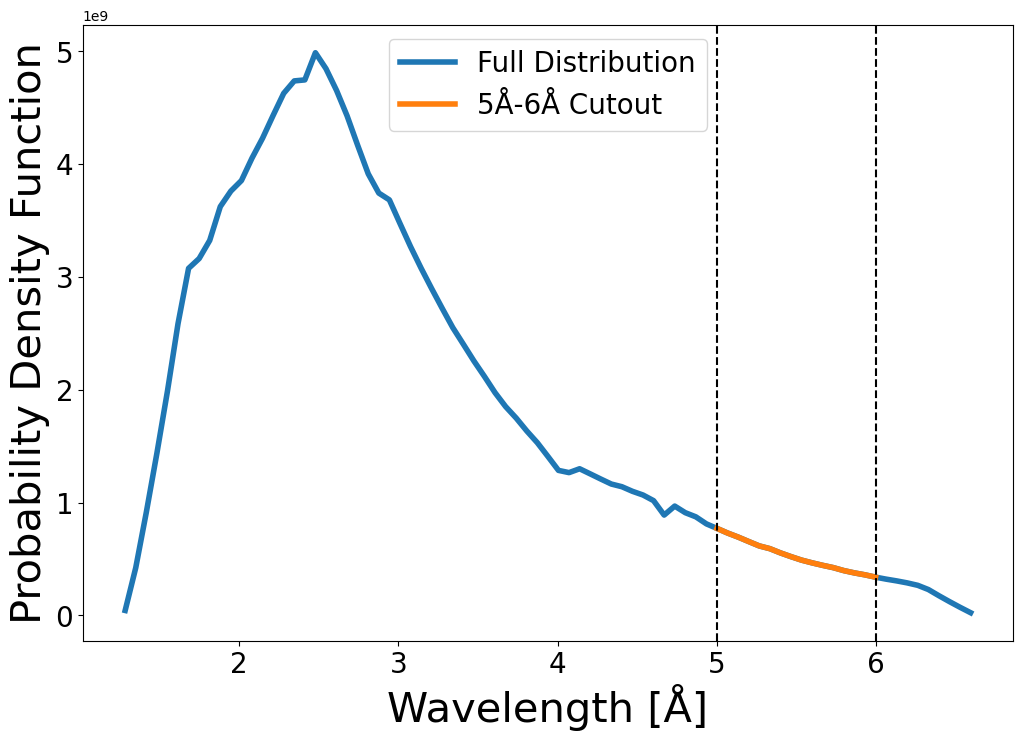

In [24]:
fig, ax1 = plt.subplots(figsize  = (12,8))

# ax1.plot(polyspectrum[0]*1e10,polyspectrum[1],lw = 4)
ax1.plot(jplam*1e10, jpplam, lw = 4, label = "Full Distribution")
ax1.plot(jplam[cutout_mask]*1e10, jpplam[cutout_mask], lw = 4, label = "5Å-6Å Cutout")

ax1.set_xlabel("Wavelength [Å]", fontsize = 30)
ax1.set_ylabel("Probability Density Function", fontsize = 30)
ax1.tick_params(labelsize = 20)
ax1.axvline(5,color = "k", ls = "--")
ax1.axvline(6,color = "k", ls = "--")

ax1.legend(fontsize = 20, loc = "upper center")
fig.savefig("jparcwavelengthdistwithcutout.png", bbox_inches = "tight")

plt.show()
plt.close(fig)

In [ ]:
Nbc = 5e28*4.149e-15
mt = 5
x0 = 0

pjp = 3e-6
xbinjp = 1e-6
ybinjp = 1e-6

jpmonolam = jplam[cutout_mask]
jpmonoplam = jpplam[cutout_mask]


hjp = 8.53e-6
jpd = np.linspace(4.5,44.5,81)*1e-3 




a_vals = np.linspace(-60,60,25)*1e-2
a = a_vals[np.array([8,13,9])]

L1jp = (96.6 + 319)*1e-2 -  np.arange(0,3,1) * 86.5e-2 - L0data



jpd,L1jp = force_broadcast(jpd,L1jp)


L1jp = L1jp - (jpd - jpd[0])/2


Ljp = 8.2955 - L0data



monophijp = Nbc*jpmonolam*hjp



jpcamsize = 1e-2

jpslits = np.linspace(400,600,9)*1e-6
jpslit = jpslits[2]

print(jpslit)

jpres = 100e-6




G1monosd = {"p":pjp, "L1": L1jp -a, "phi":monophijp}
G1monosd["L2"] = jpd - d0data


G2monosd = {"p":pjp, "L1": G1monosd["L1"] +  G1monosd["L2"], "phi":monophijp}
G2monosd["L2"] = Ljp - G2monosd["L1"]


simjpmonoapts = {"G1":RectGrating(G1monosd),"G2":RectGrating(G2monosd)}



simjpmonoinit = {"lam":jpmonolam, "plam" : jpmonoplam, "L":np.array([Ljp]),"d":G1monosd["L2"],"mt":mt, \
                 "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
                 "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),"camsize" : jpcamsize ,\
                 "convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 5000 }



In [ ]:
t0 = time()

simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
simjpmono.propagate_to("G1")
simjpmono.propagate_to("G2")
simjpmono.generate_after("G2")



    
print(time() - t0, "seconds")

In [ ]:
Nbc = 5e28*4.149e-15


jppolylam = jplam.copy()
jppolyplam = jpplam.copy()


polyphijp = Nbc*jppolylam*hjp





G1polysd = {"p":pjp, "L1": L1jp, "phi":polyphijp}
G1polysd["L2"] = jpd


G2polysd = {"p":pjp, "L1": G1polysd["L1"] +  G1polysd["L2"], "phi":polyphijp}
G2polysd["L2"] = Ljp - G2polysd["L1"]


# Ioff = np.array([500])



simjppolyapts = {"G1":RectGrating(G1polysd),"G2":RectGrating(G2polysd)}

simjppolyinit = {"lam":jppolylam, "plam" : jppolyplam, "L":Ljp,"d":G1polysd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
            "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),\
            "camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 2000, "Ioffset" : Ioff }


In [ ]:
t0 = time()
# simjppoly = PGMI(simjppolyapts,simjppolyinit)
# simjppoly.propagate_to("G1")
# simjppoly.propagate_to("G2")
# simjppoly.generate_after("G2")


# contjppolyslit = []
# fitparamsjppolyslit = []

contjppolyaslit = []
fitparamsjppolyaslit = []

# contjppolyres = []
# fitparamsjppolyres = []

# for slit in jpslits:
    
#     simjppolyinit["slitx"] = slit
#     simjppoly = PGMI(simjppolyapts,simjppolyinit)
#     simjppoly.propagate_to("G1")
#     simjppoly.propagate_to("G2")
#     simjppoly.generate_after("G2")
#     contjppolyslit.append(simjppoly.get_value("contrast"))
#     fitparamsjppolyslit.append(simjppoly.get_value("fitparams"))


for a in a_vals:
    L1 = L1jp - a
    G1polysd = {"p":pjp, "L1": L1, "phi":polyphijp}
    G1polysd["L2"] = jpd - d0data


    G2polysd = {"p":pjp, "L1": G1polysd["L1"] +  G1polysd["L2"], "phi":polyphijp}
    G2polysd["L2"] = Ljp - G2polysd["L1"]
        
    simjppolyapts = {"G1":RectGrating(G1polysd),"G2":RectGrating(G2polysd)}
    simjppolyinit = {"lam":jppolylam, "plam" : jppolyplam, "L":Ljp,"d":G1polysd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
            "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),\
            "camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 2000}
    
    for slit in jpslits:
        contjppolyaslit.append([])
        fitparamsjppolyaslit.append([])
        simjppolyinit["slitx"] = slit

        simjppoly = PGMI(simjppolyapts,simjppolyinit)
        simjppoly.propagate_to("G1")
        simjppoly.propagate_to("G2")
        simjppoly.generate_after("G2")
        contjppolyaslit[-1].append(simjppoly.get_value("contrast"))
        fitparamsjppolyaslit[-1].append(simjppoly.get_value("fitparams"))
    clear_output()
    print(np.argwhere(a == a_vals)/len(a_vals)*100, "% done")
# for res in res_vals:
    
#     simjppolyinit["res"] = res
#     simjppoly = PGMI(simjppolyapts,simjppolyinit)
#     simjppoly.propagate_to("G1")
#     simjppoly.propagate_to("G2")
#     simjppoly.generate_after("G2")
#     contjppolyres.append(simjppoly.get_value("contrast"))
#     fitparamsjppolyres.append(simjppoly.get_value("fitparams"))
    
print(time() - t0, "seconds")

In [ ]:
Ijpmono = simjpmono.get_value("intensity")
rawjpmono = simjpmono.get_value("raw")
contjpmono = simjpmono.get_value("contrast")
fitparamsjpmono = simjpmono.get_value("fitparams")
simfreqjpmono = 1/np.abs(fitparamsjpmono[...,2]) 


# Ijppoly = simjppoly.get_value("intensity")
# rawjppoly = simjppoly.get_value("raw")
# contjppoly = simjppoly.get_value("contrast")
# fitparamsjppoly = simjppoly.get_value("fitparams")
# simfreqjppoly = 1/np.abs(fitparamsjppoly[...,2]) 


In [ ]:

# contjpmonores, fitparamsjpmonores = np.array([contjpmonores]).squeeze(), np.array([fitparamsjpmonores]).squeeze()
# simfreqjpmonores = 1/np.abs(fitparamsjpmonores[...,2])
# contjppolyres, fitparamsjppolyres = np.array([contjppolyres]).squeeze(), np.array([fitparamsjppolyres]).squeeze()
# simfreqjppolyres = 1/np.abs(fitparamsjppolyres[...,2])

# contjpmonoaslit, fitparamsjpmonoaslit = np.array([contjpmonoaslit]).squeeze(), np.array([fitparamsjpmonoaslit]).squeeze()
# simfreqjpmonoaslit = 1/np.abs(fitparamsjpmonoaslit[...,2])
# contjppolyaslit, fitparamsjppolyaslit = np.array([contjppolyaslit]).squeeze(), np.array([fitparamsjppolyaslit]).squeeze()
# simfreqjppolyaslit = 1/np.abs(fitparamsjppolyaslit[...,2])

In [ ]:
# contjpmonoaslit = contjpmonoaslit.reshape(25,9,21,3)
# simfreqjpmonoaslit = simfreqjpmonoaslit.reshape(25,9,21,3)

# contjppolyaslit = contjppolyaslit.reshape(25,9,21,3)
# simfreqjppolyaslit = simfreqjppolyaslit.reshape(25,9,21,3)

### Minimization

In [ ]:
scale_arr = np.linspace(0.25,1,76)
I0_arr = scale_arr[np.array([60,60,40])]
# scale_arr, contjpmonoaslit = force_broadcast(scale_arr, contjpmonoaslit)
# contjpmonoaslit = contjpmonoaslit * scale_arr

# scale_arr, contjppolyaslit = force_broadcast(scale_arr, contjppolyaslit)
# contjppolyaslit = contjppolyaslit * scale_arr



In [ ]:
# contjpmonoaslit, datamonoconttemp = force_broadcast(contjpmonoaslit, datacont[monoindices].T)

# jpmonoerr = np.sum(np.abs(contjpmonoaslit - datamonoconttemp)**2, axis = -2)


# optimal_mono = np.array([min_index(jpmonoerr[...,i]) for i in range(3)]) 

# print(optimal_mono)


# contjppolyaslit, datapolyconttemp = force_broadcast(contjppolyaslit, datacont[polyindices].T)

# jppolyerr = np.sum(np.abs(contjppolyaslit - datapolyconttemp)**2, axis = -2)


# jptotalerr = []
# a_I0_indices = []

# for i in range(jpmonoerr.shape[-2]):
#     mono1,mono2,mono3 = jpmonoerr[...,i,0],jpmonoerr[...,i,1],jpmonoerr[...,i,2]
#     poly1,poly2,poly3 = jppolyerr[...,i,0],jppolyerr[...,i,1],jppolyerr[...,i,2]
#     tot1,tot2,tot3 = mono1+poly1,mono2+poly2,mono3+poly3
    
#     a_I0_indices.append([min_index(tot1),min_index(tot2),min_index(tot3)])
#     jptotalerr.append([tot1,tot2,tot3])
    
# a_I0_indices = np.array(a_I0_indices)
# jptotalerr = np.array(jptotalerr)
# print(min_index(jptotalerr))
# print(a_I0_indices[5])


# print(np.array(a_I0_indices))

# optimal_poly = np.array([min_index(jppolyerr[...,i]) for i in range(3)]) 

# print(optimal_poly)


# jptotalerr = jpmonoerr + jppolyerr 

# # print(jptotalerror.shape)
# optimal_inds = np.array([min_index(arr) for arr in jptotalerr]) 
# print(optimal_inds)




# print(min_index(jpblueerr))

In [ ]:

fig, ax1 = plt.subplots(figsize = (12,8))

datacont = datacont_c
datafreq = datafreq_c

markers = ["1","<","o","v","p","h","+",">", "d", "2", "3"]



ax1.set_prop_cycle(color = ["blue","red","black"])

for i, monoind in enumerate(monoindices):
    ax1.plot((ddata)*1e3, datacont[monoind], "o" )



ax1.set_prop_cycle(color = ["blue","red","black"])



[ax1.plot((jpd)*1e3, contjpmono[:,i] * I0_arr[i], label = "L1 = %.f cm" % ((L1jp-a).squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]


# for resind, res in enumerate(res_vals):
#     for i, monoind in enumerate(monoindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjpmonores[resind,:,i],markers[resind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, res size %.f um" % (L1jp.squeeze()[0,i] * 1e2, res*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])





    
# ax1.plot((jpd)*1e3, contjpmonoaslit[60,7,2,:,0] )
# ax1.plot((jpd)*1e3, contjpmonoaslit[60,13,2,:,1] )
# ax1.plot((jpd)*1e3, contjpmonoaslit[40,17,2,:,2] )





# ax1.set_title(r"JPARC Monochromatic Contrast with L = %f m, $d_0$ = [%.2f,%.2f,%.2f] mm, Detector Distance = %.3f m" % (Ljp, *(d0data*1e3), detector_dist))
ax1.set_xlabel("Separation distance $d$ [mm]", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax1.legend(fontsize = 20)
fig.savefig("JPARCMonoCont.png")
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))




ax1.set_prop_cycle(color = ["blue","red","black"])

for i, polyind in enumerate(polyindices):
    ax1.plot(ddata*1e3, datacont[polyind], "o", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )

    

# for i, polyind in enumerate(polyindices):
#     ax1.plot((ddata + d0data[i])*1e3, datacont[polyind], "--o", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )

# for i, polyind in enumerate(polyindices):
#     ax1.plot((ddata + d0data[i])*1e3, contregion[polyind], "-d", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )  
    
ax1.set_prop_cycle(color = ["blue","red","black"])

# for slitind, slit in enumerate(jpslits):
#     for i, polyind in enumerate(polyindices):
#             ax1.plot((jpd + d0data[i])*1e3, contjppolyslit[slitind,:,i],markers[slitind] + "-" ,\
#                  label = "Simulation, L1 = %.2f cm, slit size %.f um" % (L1jp.squeeze()[0,i] * 1e2, slit*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])

# for aind, a in enumerate(a_vals):
#     for i, polyind in enumerate(polyindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjppolya[aind,:,i],markers[aind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, a = %.f cm" % (L1jp.squeeze()[0,i] * 1e2, a*1e2))
#     ax1.set_prop_cycle(color = ["blue","red","black"])


# [ax1.plot((jpd + 2*d0data[i])*1e3, contjppoly[:,i]*0.85, label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

# for resind, res in enumerate(res_vals):
#     for i, polyind in enumerate(polyindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjppolyres[resind,:,i],markers[resind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, res size %.f um" % (L1jp.squeeze()[0,i] * 1e2, res*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])




    
ax1.plot((jpd)*1e3, contjppolyaslit[75,0,5,:,0] )
ax1.plot((jpd)*1e3, contjppolyaslit[65,3,5,:,1] )
ax1.plot((jpd)*1e3, contjppolyaslit[75,4,5,:,2] )
# [ax1.plot((jpd)*1e3, contjppolyaslit[75,i,2,:,2]) for i in range(6)]


ax1.set_title("JPARC Polychromatic Contrast vs. G1-G2 separation, runs of variable L1 distance")
ax1.set_xlabel("G1-G2 separation")
ax1.set_ylabel("Contrast")
ax1.legend(fontsize = 6)
# fig.savefig("jparcpolycontdataregions.jpg")
plt.show()